# Enron 2.0: Predicting California's Energy Consumption

## Team Members:

**Names:** John W. Muhs, Corbett Carell
<br>**Emails:** <u0761102,u0502104>@utah.edu</br>
<br>**Github Repository:** [JohnWMuhs/2019-datascience-project](https://github.com/JohnWMuhs/2019-datascience-project "2019 Data Science Project Github Repo")</br>

## Project Objectives

In this project, we present a power consumption prediction method for the [California ISO](http://www.caiso.com/Pages/default.aspx). CAISO is California's largest Balancing Authority and Market Independent System Operator. CAISO holds a number of responsibilities and functions to ensure a competitive, cost-effective, reliabile, and environmentally friendly energy market. For example, CAISO oversees market transactions between power industry stakeholders in California such as Generation Power Plants, Transmission Owners, Renewables Integrators and Customers.  As such, CAISO closely monitors large-scale generation and consumption trends for the State of California. 

By utilizing hourly CAISO load data from the Energy Information Agency (EIA), weather data from the Darksky API. CAISO As of Milestone 1, only these data sets are used, and correlation between weather variables and load has been found, but other data sets may be included to further improve the model. 

<img src="images/CaliforniaISO_PoweringLivesEconomy.jpg">

<img src="images/CaliforniaISO_OpenTransparentMrkt.jpg">

<img src="images/CaliforniaISO_GreeningGridFutureGen.jpg">



<br>**Project Proposal (Submitted Mar. 1st):** The project was introduced via a project proposal available on Google Docs [here](https://docs.google.com/document/d/1i6FB5gmumkx5CnaKLHzKJk8nae0PirpgJDDWm3NkkZ4/edit?usp=sharing "Project Proposal").</br>

Notes from the peer review session are included in the project proposal on the last page. We have also included the project proposal in a pdf included in the Github repository. 

**Things to add from First Milestone:**
1. Weekday vs. Weekend (Done via Pandas)
2. Number of Customer Accounts ([EIA](https://www.eia.gov/opendata/qb.php?category=1718389))
3. Percent Urban Population of California ([BEA](https://apps.bea.gov/API/signup/index.cfm))
4. Gross State Product (GSP) and/or GDP of USA ([BEA](https://apps.bea.gov/API/signup/index.cfm))
5. Split the weather data into categories
6. Try PCA
7. Try a Linear Regression, kNN Regression, and simple perceptron. 
8. Use a mean error to measure accuracy of regression
9. Could use the mean error from the best model to model accuracy on the other models. 



## Data Sources
<br>**Energy Data:** [U.S. Electric System Operating Data](https://www.eia.gov/opendata/qb.php?category=2123635 "EIA API: Electric System Operating Data")</br>
<br>**Weather Data:** [Darksky API](https://darksky.net/dev "Darksky API")</br>


# Section 1: Data Import

## Energy Data Import and Formatting

This section includes the code required to import power consumption from the CAISO Balancing Authority (BA) and the entire California region. The California region contains a number of BAs (the largest of which by far is CAISO), however, we decided to import both BA and region data for comparison. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests 
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy as sc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale 
from sklearn.decomposition import PCA 
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:.2f}'.format

The code below allows a user to quickly copy/paste a link from the EIA API website, and provide a title for it in the urls dictionary. The code takes that url and creates a unified dataframe. Therefore, it is incredibly easy to add additional EIA data in the future. 

In [2]:
# Import EIA API Key 
EIA_api_key = '53e6a63887dc05efe150165fa890f8da'

# Create Dictionary of urls from which we want to pull the EIA API
urls = {'CAISO_HourlyLoad':'http://api.eia.gov/series/?api_key='+EIA_api_key+'&series_id=EBA.CISO-ALL.D.H',
        'California_HourlyLoad':'http://api.eia.gov/series/?api_key='+EIA_api_key+'&series_id=EBA.CAL-ALL.D.H'}


In [3]:
# Initialize a dataframe
df = pd.DataFrame()

# Setup dummy variable to ensure that a datetime is only generated once
i = 0

for key in urls:
    
    # API pull
    EIAData = requests.get(urls[key])
    
    # Decode from utf-8
    EIAData = EIAData.content.decode("utf-8")
    
    # Load API pull as a dict
    EIAdict = json.loads(EIAData)
    
    # Access the data in EIAdict
    dfEIA = pd.DataFrame.from_dict(EIAdict['series'])
    dfEIA = dfEIA['data'][0]
    
    # Convert clean data to a dataframe
    dfEIA = pd.DataFrame(dfEIA)
    #print(dfEIA[0])
    
    # Find the datetime
    while i != 1:
        df['DateTime'] = pd.to_datetime(dfEIA[0],format='%Y%m%dT%H', errors='ignore',utc = True)
        df['DateTime'] = df['DateTime'].dt.tz_convert('US/Pacific')
        i += 1
    
    # Create a new column for each type of data (url) pulled from API
    df[str(key)] = dfEIA[1]
    
# Set DateTime as index of the dataframe (tz-aware)
df.index = df['DateTime']

In [4]:
df.head()

,DateTime,CAISO_HourlyLoad,California_HourlyLoad
DateTime,,,
2019-04-19 09:00:00-07:00,2019-04-19 09:00:00-07:00,22640.00,27739
2019-04-19 08:00:00-07:00,2019-04-19 08:00:00-07:00,22730.00,27617
2019-04-19 07:00:00-07:00,2019-04-19 07:00:00-07:00,22295.00,27036
2019-04-19 06:00:00-07:00,2019-04-19 06:00:00-07:00,20972.00,25419
2019-04-19 05:00:00-07:00,2019-04-19 05:00:00-07:00,19764.00,23909


We decided to complete the project in a daily time resolution. This was done mainly to reduce the dataset to a reasonable size. If we kept the dataset at an hourly time resolution, we would have over 32,000 data points! However converting the data down to a daily time resolution provided a very nicely-sized 1362 data points from which to analyze. 

In [5]:
# Resample hourly data to daily data (summed energy consumption which has units of MWh)
df = df.resample('D').sum()

In [6]:
# Add a column that determines whether or not a date is a weekday or weekend day.
df['isWeekend'] = np.ones(df.shape[0]).astype(int)
df['isWeekend'] = df['isWeekend'].where((df.index.weekday == 5) | (df.index.weekday == 6),0).astype(int)

#Add index of Month and Day of Year
df['Month'] = df.index.month
df['DayofYear'] = df.index.dayofyear

In [7]:
# Read in Customer Accounts (pulled from EIA API in file "EIA_API-MonthlyCustomerCount.ipynb")
dfCustomerAccts = pd.read_csv('CustomerAccts.csv')

# Parse DateTime from string to pandas datetime
dfCustomerAccts['DateTime'] = pd.to_datetime(dfCustomerAccts['DateTime'],format='%Y-%m-%d', errors='ignore')

# Set datetime as index
dfCustomerAccts.index = dfCustomerAccts['DateTime']

# Delete extraneous column
dfCustomerAccts = dfCustomerAccts.drop('DateTime',axis=1)

# Localize Timezone to Pacific
dfCustomerAccts = dfCustomerAccts.tz_localize('US/Pacific', level=0)

In [8]:
df = pd.merge(df,dfCustomerAccts, how='inner', left_index=True, right_index=True)

The final dataframe looks like this:

In [9]:
df.head()

,CAISO_HourlyLoad,California_HourlyLoad,isWeekend,Month,DayofYear,CA_CustomerCount
DateTime,,,,,,
2015-07-01 00:00:00-07:00,759794.00,940489,0,7,182,15720942.00
2015-07-02 00:00:00-07:00,780410.00,962751,0,7,183,15696530.84
2015-07-03 00:00:00-07:00,719208.00,887079,0,7,184,15672119.68
2015-07-04 00:00:00-07:00,678520.00,830874,1,7,185,15647708.52
2015-07-05 00:00:00-07:00,649346.00,791310,1,7,186,15623297.35


We used the following code to export this dataframe to a csv.

In [10]:
#df.to_csv('energydata.csv')

## Weather Data (DarkSky API) Import and Format

The weather data was pulled in using the DarkSky API. The Darksky API requires inputs of latitude, longitude, and datetime to pull corresponding weather data. Darksky API does not seem to allow pulls over a date range, so for this reason, the code to pull over the entire date range required over 6,000 pulls from the API. So as not to do this every time we run the code, a separate code has been developed and included in the repository that demonstrates how DarkSky data was accessed. The code to pull the weather data can be found in "darksky-api.ipynb".

Weather data was pulled from July 1st, 2015 (constraint from EIA hourly data) to December 31st, 2018 from 5 weather stations across diverse geographic regions of California. The weather data included in the darksky_data.csv file represents the average of the values across the 5 selected weather stations. Only the averaged values were included in the final notebook in hopes to simplify the analysis. All filtering and processing will be included in this notebook. 

In [11]:
# Pull weather data from static csv
dfWeather = pd.read_csv('darksky_data.csv')

#Set dummy variable
i=0

In [12]:
# To avoid renaming multiple times and pulling an error (we could include a try except here.)
while i != 1:
    #Take the date time (originally included as a string), and format it into a pd datetime
    dfWeather['DateTime'] = pd.to_datetime(dfWeather['time'],format='%m-%d-%Y', errors='ignore')
    
    # Set Datetime as index of the dataframe
    dfWeather.index = dfWeather['DateTime']
    
    # Drop extraneous columns
    dfWeather = dfWeather.drop(['time','DateTime'],axis=1)
    
    # Set TZ to US-Pacific (both dataframes are tz-aware)
    dfWeather = dfWeather.tz_localize('US/Pacific', level=0)
    i += 1


# Section 2: Data Merge and Visualization

For this model, we utilize to use a subset of available information about a given day to determine the CAISO consumption for that given day. In this model, we have considered all of the following learning variables: 

* **isWeekend:** Binary variable that denotes Saturday or Sunday (1) or a weekday (0)
* **Month:** Interger from 0 to 11 which denotes the month of the year
* **Day of Year:** Interger from 0 to 364 which denotes the day of the year
* **California Power Customer Count** Number of EIA customers (see EIA_API-MonthlyCustomerCount.ipynb)
* **Gross Domestic Product:** National GDP of the US (see BEA_GDP.ipynb)
* **California Population:** Population of the State of California (from BEA)
* **Temperature Values:** Max and Min Observed and Apparent ("feels like") Temperatures
* **Dew Point:** Dew Point readings
* **Precipitation:** Precipitation probability and intensity readings
* **Other Weather Parameters:** Including Barometric Pressure, UV Index, Wind Speed, etc. See [Darksky API Website](https://darksky.net/dev/docs) for description of all available weather parameters

In [13]:
#dfX.columns

In [14]:
# Merge EIA and Weather dataframes. Inner only keeps the dates from the dfWeather dataframe. 
dfX = pd.merge(df,dfWeather, how='inner', left_index=True, right_index=True)

In [15]:
# Import and Clean California Population Data
df_pop = pd.read_csv('calpop.csv')
df_di = pd.Series(pd.date_range(start='7/1/2015', end = '12/31/2018', tz = 'US/Pacific'))
df_pop = pd.concat([df_di, df_pop], axis = 1)
df_pop['Datetime'] = df_pop[0]
df_pop.index = df_pop['Datetime']
df_pop.drop(['Date', 'Datetime', 0],axis = 1, inplace = True)

In [16]:
# Import and Clean California GDP Data
df_gdp = pd.read_csv('bea_gdp.csv')
df_gdp = pd.concat([df_di, df_gdp], axis = 1)
df_gdp['Datetime'] = df_gdp[0]
df_gdp.index = df_gdp['Datetime']
df_gdp.drop(['Date', 'Datetime', 0],axis = 1, inplace = True)

In [17]:
# Concatenate Existing Dataframe (dfX) with GDP and Population Series
dfX = pd.concat([dfX, df_gdp, df_pop], axis=1)

In [18]:
#dropping na values and dropping California houylr_load since we will be using CASIO_hourlyload data as our depenedent variable for models
dfX = dfX.dropna()
dfX = dfX.drop(['California_HourlyLoad'], axis = 1)

# Filter Outliers of Data (please see CAISOFiltering.ipynb for reasoning)
dfX = dfX[dfX['CAISO_HourlyLoad'] > 400000]

dfX.head()

,CAISO_HourlyLoad,isWeekend,Month,DayofYear,CA_CustomerCount,apparentTemperatureHigh,apparentTemperatureLow,apparentTemperatureMax,apparentTemperatureMin,cloudCover,...,temperatureLow,temperatureMax,temperatureMin,uvIndex,visibility,windBearing,windGust,windSpeed,GDP,CAPOP
DateTime,,,,,,,,,,,,,,,,,,,,,
2015-07-01 00:00:00-07:00,759794.00,0,7,182,15720942.00,99.14,76.57,99.14,76.39,0.24,...,76.35,98.33,76.21,9.20,8.45,191.60,13.93,1.19,18295290.61,39080082.51
2015-07-02 00:00:00-07:00,780410.00,0,7,183,15696530.84,96.23,72.28,96.23,76.17,0.22,...,72.22,95.88,76.04,9.80,8.40,247.40,11.84,1.94,18296484.02,39080783.84
2015-07-03 00:00:00-07:00,719208.00,0,7,184,15672119.68,96.16,71.09,96.16,72.28,0.16,...,71.05,96.01,72.22,10.40,8.95,254.40,11.07,2.23,18297677.43,39081485.16
2015-07-04 00:00:00-07:00,678520.00,1,7,185,15647708.52,97.32,70.61,97.32,70.97,0.16,...,70.60,96.99,70.95,10.20,9.02,249.20,12.00,2.38,18298870.85,39082186.49
2015-07-05 00:00:00-07:00,649346.00,1,7,186,15623297.35,92.23,67.74,92.23,70.61,0.21,...,67.73,92.20,70.60,9.80,9.01,247.40,12.47,3.15,18300064.26,39082887.82


/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0,0.5,'Dew Point (°C)')

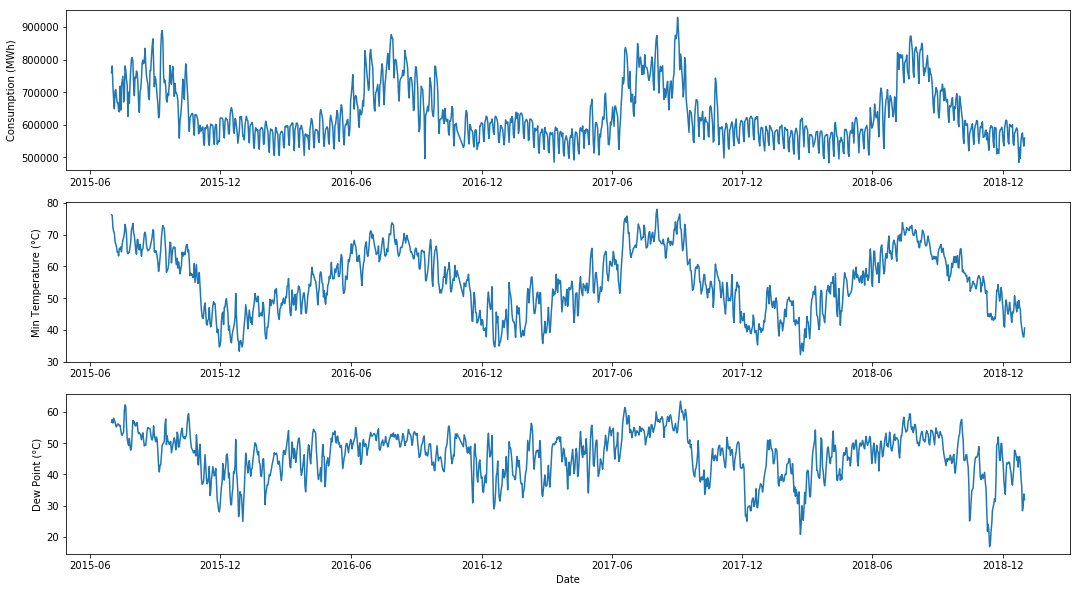

In [19]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(18, 10))
#start_date = ["2016-01-01","2017-01-01","2018-01-01"]
#end_date = ["2016-12-31","2017-12-31","2018-12-31"]
 
#ax0.set_title('CAISO Consumption 2016 - 2018')
ax0.plot(dfX['CAISO_HourlyLoad'])
ax0.set_ylabel('Consumption (MWh)')
ax1.plot(dfX['temperatureMin'])
ax1.set_ylabel('Min Temperature (°C)')
ax2.plot(dfX['dewPoint'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Dew Point (°C)')

#df2017.head()

In the subplots, we can begin to see that CAISO energy consumption follows weekly, seasonal, and annual trends. For example, each year in the late summer months, we see a spike in energy consumption. We believe this is predominately due to air conditioning. The EIA provides additional information about residential air conditioning use and its contribution to higher energy consumption on their [website](https://www.eia.gov/consumption/residential/reports/2009/air-conditioning.php). 

We can see that averaged weather patterns for the state of California also follow these seasonal trends, which suggests that weather data (namely temperature) and CAISO energy consumption are correlated. 

# Section 3: Dimension Reduction

## Dimension Reduction: Visual Interpretation of Correlations

Text(0.5,1,'Correlations in Energy Prediction Dataset')

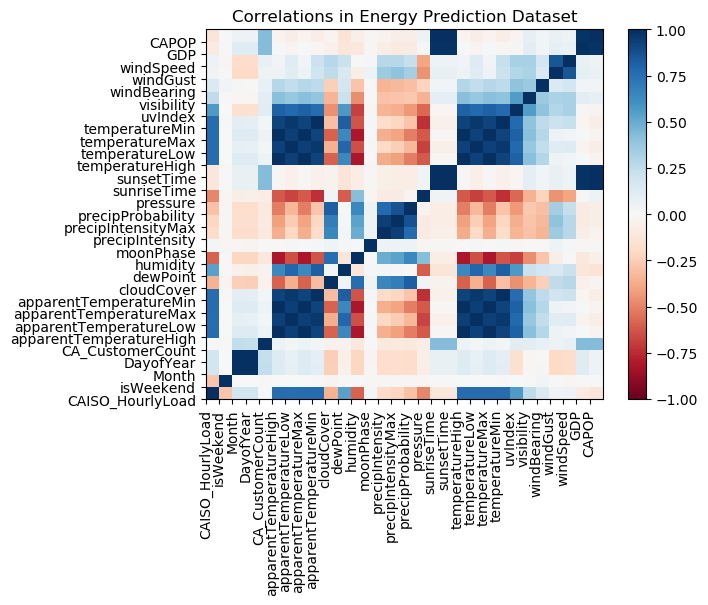

In [20]:
# 
# calculate and visualize correlations as matrix
plt.style.use('default')

# select a blue color map and define vmin
heatmap = plt.pcolor(dfX.corr(), cmap='RdBu', vmin=-1)

# plot the legend on the side
plt.colorbar(heatmap)

# Define the tick marks so that they can be easily read
plt.xticks(np.arange(len(dfX.columns)), dfX.columns, rotation='vertical')
plt.yticks(np.arange(len(dfX.columns)), dfX.columns, rotation='horizontal')
plt.title('Correlations in Energy Prediction Dataset')

**Note:** A diverging colormap was chosen so as to show a faded color at correlation values of zero.

As can be seen in the correlation heatmap above, we can make two major observations, looking predomately at the correlations between CAISO load (left-most column), and all other values: 

First, many of the temperature values from the DarkSky API highly correlated and are thus redundant. Therefore, out of the many variations of temperature, we decided to choose apparent temperature min and aparent temperature max. We chose these values because, as previously mentioned, they can be interpreted as "feels like" temperature, and thus may better indicate human behavior. 


In [21]:
# Drop Extraneous Temperature Columns
dfX = dfX.drop(['apparentTemperatureHigh','apparentTemperatureLow','temperatureHigh','temperatureLow','temperatureMin','temperatureMax'],axis=1)

The second observation we can make is that many of the weather values are uncorrelated to CAISO energy consumption. We see that temperature has the highest correlation, with dew point, humidity, barometric pressure, and UV index coming in next. Below we have provided commented code that, when uncommented, will allow you to see the numerical values of the correlations.

In [22]:
# Determine Correlations between all variables and CAISO Load
corr = dfX.corr()['CAISO_HourlyLoad'].sort_values()
#print(corr)

In [23]:
# Drop extraneous weather variables
dfX = dfX.drop(['cloudCover','precipProbability','precipIntensityMax','precipIntensity','sunriseTime','sunsetTime','moonPhase','windGust','windSpeed','windBearing','visibility'],axis=1)

In [24]:
print(dfX.columns)
#print(len(dfX.columns))

Index(['CAISO_HourlyLoad', 'isWeekend', 'Month', 'DayofYear',
       'CA_CustomerCount', 'apparentTemperatureMax', 'apparentTemperatureMin',
       'dewPoint', 'humidity', 'pressure', 'uvIndex', 'GDP', 'CAPOP'],
      dtype='object')


We have now limited our variables down to 13 columns. We decided to keep in many of the non-weather columns regardless of their correlation to CAISO load mainly out of personal interest. A scatter plot matrix of a chosen subset of the columns is shown below. 

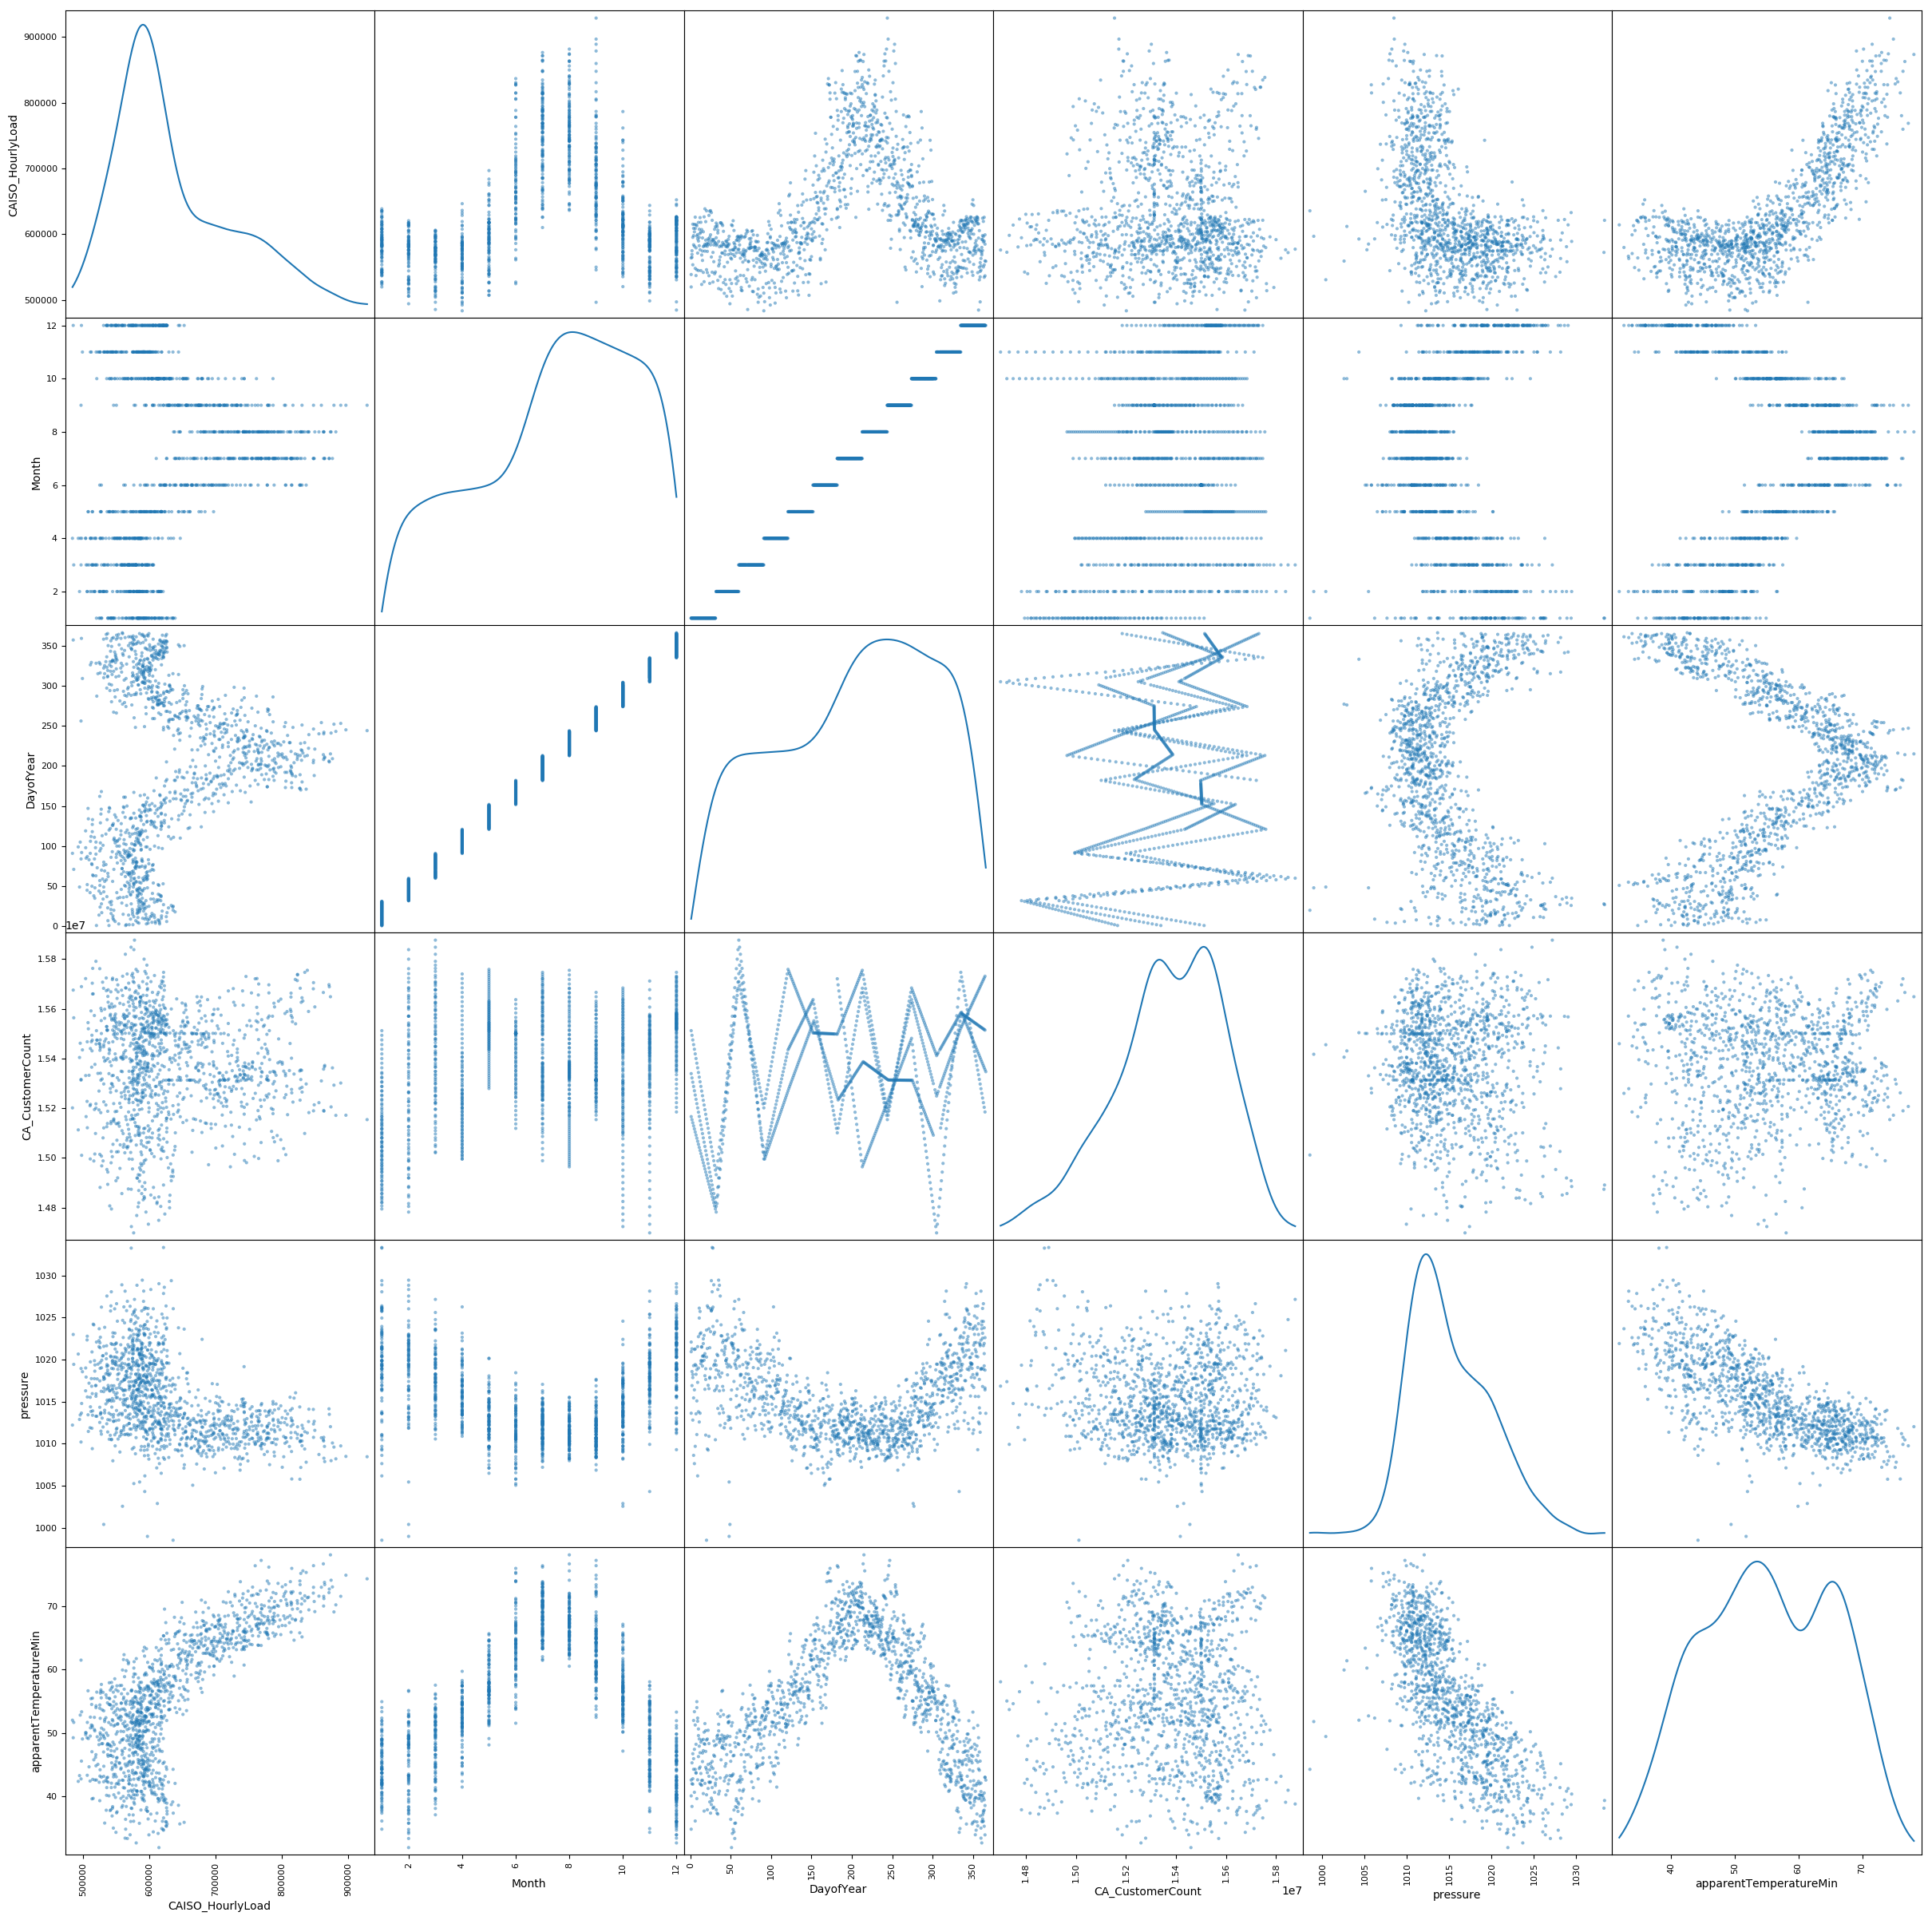

In [25]:
df_slim_1 = dfX[['CAISO_HourlyLoad', 
               'Month', 
               'DayofYear',
               'CA_CustomerCount',
               'pressure',     
               'apparentTemperatureMin']]

pd.plotting.scatter_matrix(df_slim_1, figsize=(30, 30), diagonal='kde')
plt.show()

In the scatterplot matrix, we can see a number of interesting correlation phenomena:
1. The temperature correlates to the CAISO Load in an interesting way (see top right scatterplot). There seems to be a threshold that occurs at approximately 60 degrees Fahrenheit, after which, the energy consumption increases nearly linearly with temperature. This, to us, further validates the assumption that Air Conditioners are more likely be running on days where the temperature is higher. 
2. The pressure exhibits a similarly interesting phenomena wherein the lower the pressure is, the more energy tends to be consumed. 
3. There seems to be little to no correlation with California customer count and CAISO load.
4. The Day of the Year produces a fairly tight-fit curve that denotes higher CAISO consumption in the summer months. 
5. Month similarly reflects the same phenomena as Day of the Year, but in a more granular way -- thus it could likely be considered redundant and thus dropped.

## Dimension Reduction: Principal Component Analysis

[3.60886704e-01 2.13645885e-01 1.55687987e-01 8.33948063e-02
 7.60995549e-02 5.71642102e-02 3.53366790e-02 1.30392085e-02
 2.42707009e-03 1.44565602e-03 5.84129654e-04 2.88109867e-04]
-------------------------------------


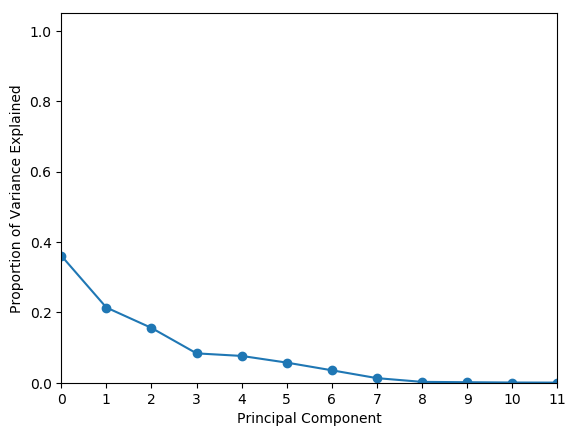

In [26]:
# Perform Principal Component Analysis on Dataset
X = dfX.drop('CAISO_HourlyLoad',axis=1).values

# Use Scale from Sklearn-preprossessing 
X_scale = scale(X)

pca_model = PCA()
energy_pca = pca_model.fit_transform(X_scale)

dfPCA = pd.DataFrame(energy_pca, columns=['PC1', 
                                           'PC2',
                                           'PC3', 
                                           'PC4', 
                                           'PC5',
                                           'PC6', 
                                           'PC7', 
                                           'PC8', 
                                           'PC9', 
                                           'PC10',
                                           'PC11',
                                           'PC12'])

dfPCA.index = dfX.index

# Variance ratio of the four principal components
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)
print('-------------------------------------')

plt.plot(range(len(dfPCA.columns)), var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks(range(len(dfPCA.columns)))
plt.show()

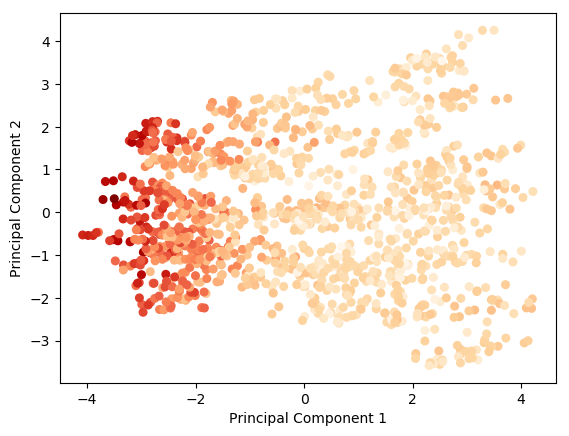

In [27]:
from matplotlib.colors import ListedColormap

cmap_ = 'OrRd'

y = dfX.CAISO_HourlyLoad

plt.scatter(energy_pca[:, 0], energy_pca[:, 1], c=y, cmap=cmap_, s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We have split the data into Principal Components. We see that the PCA is not incredibly effective since the first and second principal components only describe 36% and 21% of the variance of the data respectively. Therefore, we do not expect much improvement from the PCA when running regression learning models. 

# Section 4: Statistical Observations (via Stats Linear Regression)

**Corbett includes his work using stats linear regression here).** Fit a stats linear regression to dfX and describe the statistical findings (R-squared, p-value, F value, etc).

In [28]:
import statsmodels.formula.api as sm

ols1 = sm.ols(formula='CAISO_HourlyLoad ~ isWeekend + DayofYear + CA_CustomerCount + apparentTemperatureMax + apparentTemperatureMin + dewPoint + uvIndex + GDP + CAPOP + pressure + humidity', 
              data=dfX).fit()

ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     331.5
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:37:02   Log-Likelihood:                -15328.
No. Observations:                1267   AIC:                         3.068e+04
Df Residuals:                    1255   BIC:                         3.074e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.697e+06   1.35e+06     -1.260      0.208   -4.34e+06    9.46e+05
isWeekend              -5.221e+04   2718.465    -19.207      0.000   -5.75e+04   -4.69e+04
DayofYear                 61.6018     15.324      4.020      0.000      31.538      91.665
CA_CustomerCount           0.0115      0.007      1.673      0.095      -0.002       0.025
apparentTemperatureMax  6073.3752    593.240     10.238      0.000    4909.524    7237.227
apparentTemperatureMin  1.023e+04    708.251     14.439      0.000    8837.217    1.16e+04
dewPoint               -1.145e+04   1135.772    -10.085      0.000   -1.37e+04   -9225.737
uvIndex                  -89.4488   1017.101     -0.088      0.930   -2084.854    1905.957
GDP                       -0.0143      0.007     -1.924      0.055      -0.029       0.000
CAPOP                      0.0079      0.036      0.221      0.825      -0.062       0.078
pressure                1295.6075    400.289      3.237      0.001     510.298    2080.917
humidity                5.477e+05   6.57e+04      8.339      0.000    4.19e+05    6.77e+05
==============================================================================
Omnibus:                       19.156   Durbin-Watson:                   0.365
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.655
Skew:                           0.239   Prob(JB):                     1.99e-05
Kurtosis:                       3.426   Cond. No.                     5.12e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.12e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:** We used the stats model package to evaluate our data with linear regression. We started by creating a linear model with all 12 independent variables. The initial linear model has an adjusted R squared of 0.742 which is a good starting point. There are some independent variables with high p-values (CA_CustomerCount, uvIndex, CAPOP) indicating that they are probably not statically significant to our model and our model would perform better without them. 

In [29]:
ols2 = sm.ols(formula='CAISO_HourlyLoad ~ isWeekend + DayofYear + apparentTemperatureMax + apparentTemperatureMin + dewPoint + GDP + pressure + humidity', 
              data=dfX).fit()

ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     455.4
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:37:02   Log-Likelihood:                -15330.
No. Observations:                1267   AIC:                         3.068e+04
Df Residuals:                    1258   BIC:                         3.072e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.191e+06   4.03e+05     -2.953      0.003   -1.98e+06      -4e+05
isWeekend              -5.225e+04   2718.407    -19.221      0.000   -5.76e+04   -4.69e+04
DayofYear                 66.3125     12.258      5.410      0.000      42.263      90.362
apparentTemperatureMax  6063.8541    568.624     10.664      0.000    4948.299    7179.409
apparentTemperatureMin  1.008e+04    666.086     15.130      0.000    8771.190    1.14e+04
dewPoint               -1.132e+04    978.657    -11.572      0.000   -1.32e+04   -9404.829
GDP                       -0.0115      0.001     -7.964      0.000      -0.014      -0.009
pressure                1227.6122    397.319      3.090      0.002     448.132    2007.093
humidity                 5.43e+05   5.52e+04      9.830      0.000    4.35e+05    6.51e+05
==============================================================================
Omnibus:                       19.038   Durbin-Watson:                   0.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.358
Skew:                           0.241   Prob(JB):                     2.30e-05
Kurtosis:                       3.415   Cond. No.                     6.40e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.4e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:** After removing the variables CA_CustomerCount, uvIndex, and CAPOP the adjusted R squared of our model mainly stayed the same at 0.742. We did see a good increase in the F-stat of the model from 331.5 to  455.4. Looking at the scatter plot matrix it appears that apparentTemperatureMax and apparentTemperatureMin could have more of an exponential rather a linear relationship with our dependent variable. 

In [30]:
ols3 = sm.ols(formula='CAISO_HourlyLoad ~ isWeekend + DayofYear + I(apparentTemperatureMin ** 3)+ I(apparentTemperatureMax ** 3)+ dewPoint + GDP + humidity', 
              data=dfX).fit()

ols3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       CAISO_HourlyLoad   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     1411.
Date:                Fri, 19 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:37:02   Log-Likelihood:                -14810.
No. Observations:                1267   AIC:                         2.964e+04
Df Residuals:                    1259   BIC:                         2.968e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       6.231e+05   2.18e+04     28.553      0.000     5.8e+05    6.66e+05
isWeekend                      -5.376e+04   1802.382    -29.825      0.000   -5.73e+04   -5.02e+04
DayofYear                         56.5961      8.116      6.973      0.000      40.674      72.518
I(apparentTemperatureMin ** 3)     0.8718      0.035     24.813      0.000       0.803       0.941
I(apparentTemperatureMax ** 3)     0.3500      0.014     24.838      0.000       0.322       0.378
dewPoint                       -9705.8320    335.427    -28.936      0.000   -1.04e+04   -9047.774
GDP                               -0.0084      0.001     -8.809      0.000      -0.010      -0.007
humidity                        5.169e+05   1.94e+04     26.613      0.000    4.79e+05    5.55e+05
==============================================================================
Omnibus:                       94.473   Durbin-Watson:                   0.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              267.805
Skew:                          -0.375   Prob(JB):                     7.03e-59
Kurtosis:                       5.124   Cond. No.                     5.68e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Interpretation:** By cubing both apparentTemperatureMax and apparentTemperatureMin we an increase in the adjusted R squared of our model from 0.742 to 0.887. This means that by cubing the temperature variables we were to improve the overall fit of our regression model. We also see a significant increase if the F-stat from 455.4 to 1411. This indicts that we were able to improve the overall statistical significance of our regression model. Now that we have a linear that appears to be a good fit for our data and has a high statistical significance we need to test our model to see how well it able to predict actually load generation.

# Section 5: Developing Training and Test Data

In [64]:
# Split the dataframe into Training and Test Datasets as of the date January 1st 2018.
dfTrain = dfX[dfX.index < pd.to_datetime('January 1 2018').tz_localize('US/Pacific')].dropna()
dfTest = dfX[dfX.index >= pd.to_datetime('January 1 2018').tz_localize('US/Pacific')].dropna()

dfTrain_x_scaled = scale(dfTrain[['isWeekend',  
                                  'dewPoint',
                                  'apparentTemperatureMax', 
                                  'apparentTemperatureMin',
                                  'humidity',
                                  'DayofYear',
                                  'GDP']])

dfTrain_y = dfTrain['CAISO_HourlyLoad']

dfTest_x_scaled = scale(dfTest[['isWeekend',  
                                  'dewPoint',
                                  'apparentTemperatureMax', 
                                  'apparentTemperatureMin',
                                  'humidity',
                                  'DayofYear',
                                  'GDP']])

dfTest_y = dfTest['CAISO_HourlyLoad']


# Specificy X and y Training and Test Matrices
X_train, X_test, y_train, y_test = dfTrain_x_scaled, dfTest_x_scaled, dfTrain_y, dfTest_y


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.


In [65]:
dfX['apparentTemperatureMax3'] = dfX['apparentTemperatureMax']**3
dfX['apparentTemperatureMin3'] = dfX['apparentTemperatureMin']**3

Xcols = ['isWeekend',  
         'dewPoint',
         'apparentTemperatureMax3', 
         'apparentTemperatureMin3',
         'humidity',
         'DayofYear',
         'GDP']

dfTrain = dfX[dfX.index < pd.to_datetime('January 1 2018').tz_localize('US/Pacific')].dropna()
dfTest = dfX[dfX.index >= pd.to_datetime('January 1 2018').tz_localize('US/Pacific')].dropna()

X_train_lr, X_test_lr, y_train_lr, y_test_lr = dfTrain[Xcols], dfTest[Xcols], dfTrain['CAISO_HourlyLoad'], dfTest['CAISO_HourlyLoad']



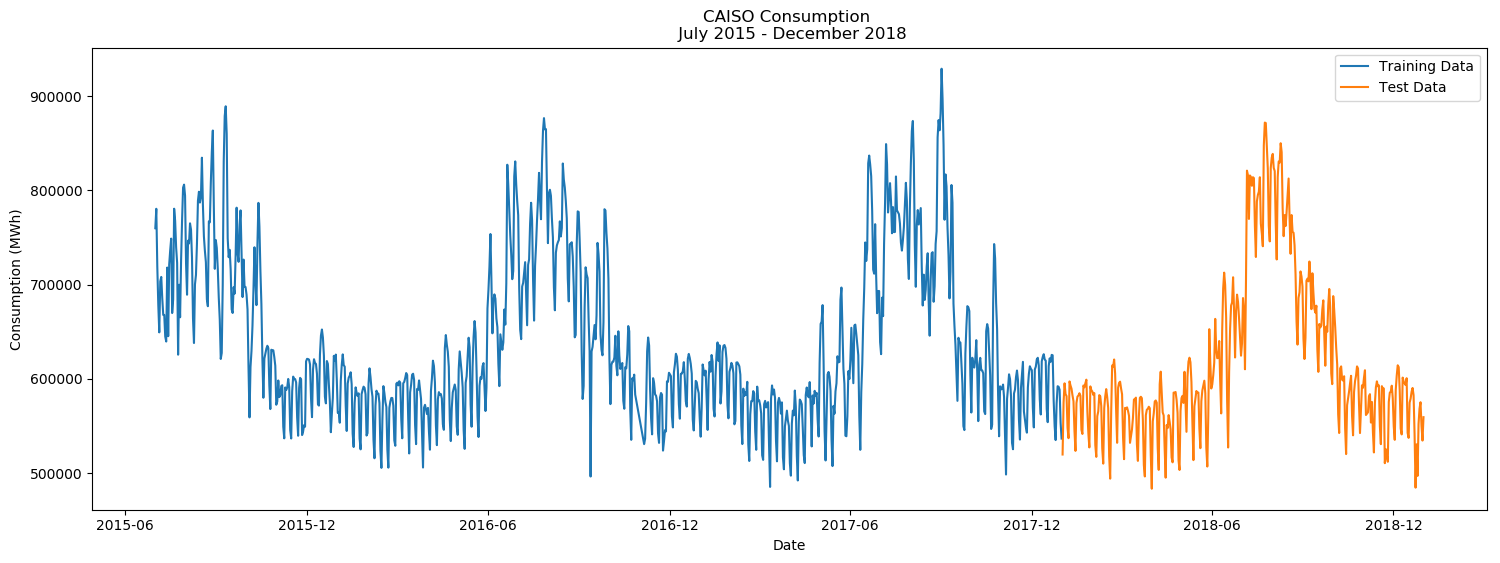

In [66]:
# Plot the Training and Test Data for the duration of the analysis. 
fig, (ax0) = plt.subplots(nrows=1, figsize=(18, 6))
ax0.set_title('CAISO Consumption \n July 2015 - December 2018')
ax0.plot(y_train,label='Training Data')
ax0.plot(y_test,label='Test Data')
ax0.set_xlabel('Date')
ax0.set_ylabel('Consumption (MWh)')
ax0.legend();

# Section 6: Sci-Kit Learn Linear Regression

In this section, we present the results from the sci-kit learn regression approach: 

In [67]:
# Import linear model
lr = linear_model.LinearRegression()

## Approach 1: Linear Regression using Empirical Variables

In [68]:
lr.fit(X_train_lr, y_train_lr)
y_pred_lr = lr.predict(X_test_lr)

In [69]:
dfLR = pd.DataFrame([y_pred_lr,y_test_lr]).T
dfLR.columns = ['Emp_Pred','CAISO_HourlyLoad']
dfLR.index = y_test_lr.index
dfLR['Emp_Error'] = dfLR['Emp_Pred'] - dfLR['CAISO_HourlyLoad']
dfLR['Emp_percentError'] = dfLR['Emp_Error']/dfLR['CAISO_HourlyLoad']*100
dfLR['Emp_isOverEstimate'] = np.where(dfLR['Emp_Error'] > 0,1,0)
dfLR.head()

,Emp_Pred,CAISO_HourlyLoad,Emp_Error,Emp_percentError,Emp_isOverEstimate
DateTime,,,,,
2018-01-01 00:00:00-08:00,569167.74,519816.00,49351.74,9.49,1
2018-01-02 00:00:00-08:00,569944.44,574949.00,-5004.56,-0.87,0
2018-01-03 00:00:00-08:00,564479.08,595318.00,-30838.92,-5.18,0
2018-01-04 00:00:00-08:00,588564.02,583949.00,4615.02,0.79,1
2018-01-05 00:00:00-08:00,586962.04,581762.00,5200.04,0.89,1


## Approach 2: Linear Regression using Principal Components

In [70]:
# Split the dataframe into Training and Test Datasets as of the date January 1st 2018.
dfTrainPCA = dfPCA[dfPCA.index < pd.to_datetime('January 1 2018').tz_localize('US/Pacific')].dropna()
dfTestPCA = dfPCA[dfPCA.index >= pd.to_datetime('January 1 2018').tz_localize('US/Pacific')].dropna()

PCACols = ['PC1','PC2','PC3','PC4']

# Specificy X and y Training and Test Matrices
XPCA_train, XPCA_test, y_train, y_test = dfTrainPCA[PCACols], dfTestPCA[PCACols], dfTrain['CAISO_HourlyLoad'], dfTest['CAISO_HourlyLoad']


In [71]:
lr.fit(XPCA_train, y_train)
y_pred_PCAlr = lr.predict(XPCA_test)

In [72]:

dfLR['PCA_Pred'] = y_pred_PCAlr
dfLR['PCA_Error'] = dfLR['PCA_Pred'] - dfLR['CAISO_HourlyLoad']
dfLR['PCA_percentError'] = dfLR['PCA_Error']/dfLR['CAISO_HourlyLoad']*100
dfLR['PCA_isOverEstimate'] = np.where(dfLR['PCA_Error'] > 0,1,0)
# dfLR.head()

## Results: Energy Consumption Predictions from Linear Regression

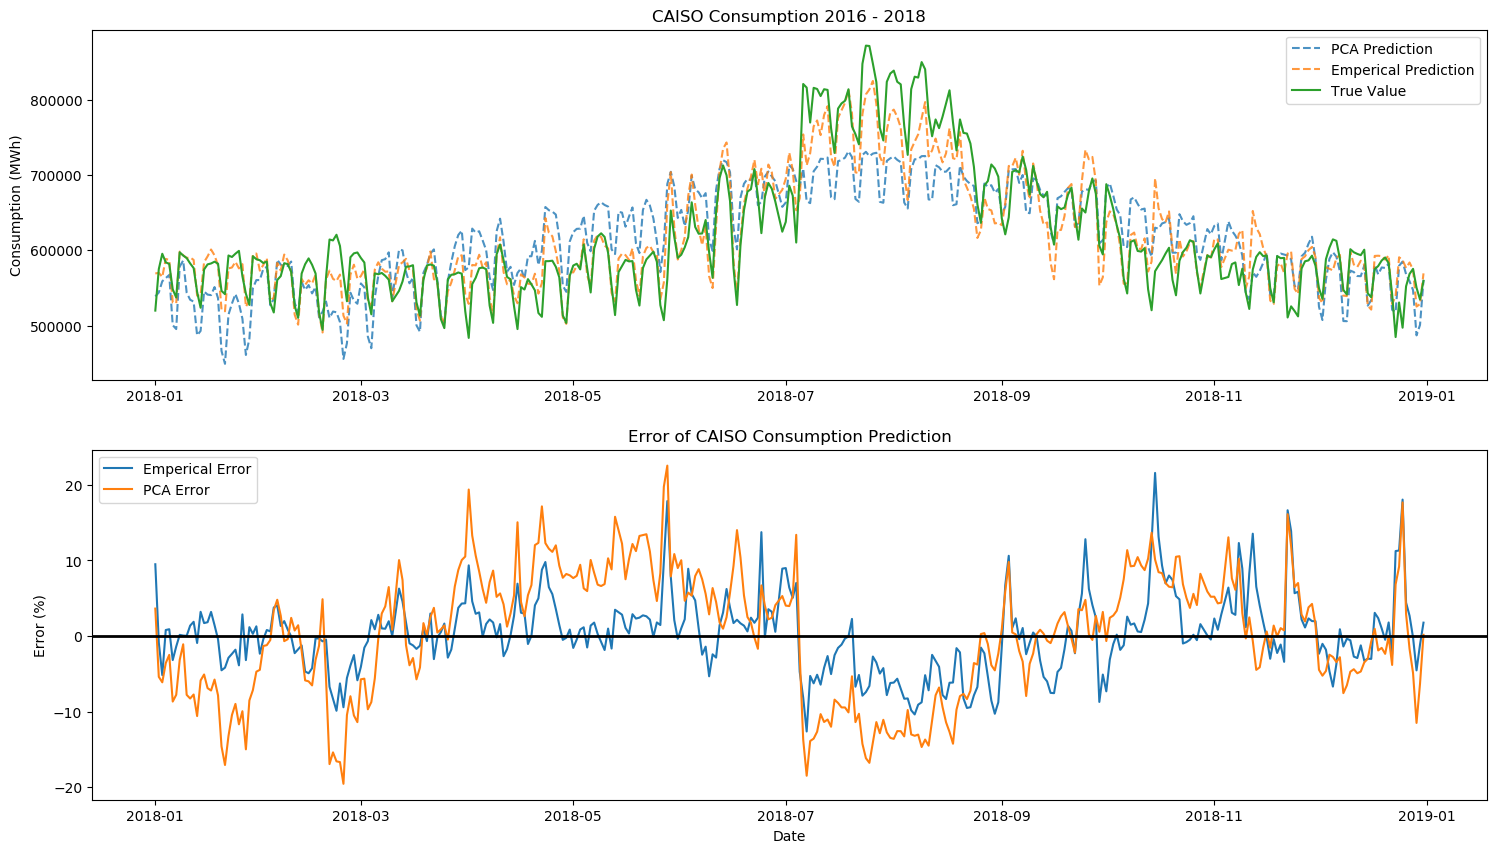

In [73]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(18, 10))
#start_date = ["2016-01-01","2017-01-01","2018-01-01"]
#end_date = ["2016-12-31","2017-12-31","2018-12-31"]
 
ax0.set_title('CAISO Consumption 2016 - 2018')
ax0.plot(dfLR.index,dfLR['PCA_Pred'],label='PCA Prediction',alpha=0.8,ls='dashed')
ax0.plot(dfLR.index,dfLR['Emp_Pred'],label='Emperical Prediction',alpha=0.8,ls='dashed')
ax0.plot(dfLR.index,dfLR['CAISO_HourlyLoad'],label='True Value')
#ax0.set_xlabel('Date')
ax0.set_ylabel('Consumption (MWh)')
ax0.legend()

ax1.set_title('Error of CAISO Consumption Prediction')
ax1.plot(dfLR.index,dfLR['Emp_percentError'],label='Emperical Error')
ax1.plot(dfLR.index,dfLR['PCA_percentError'],label='PCA Error')
ax1.set_xlabel('Date')
ax1.set_ylabel('Error (%)')
ax1.axhline(y=0,linewidth=2, color='black')
#ax1.fill_between(0, percent_error_lr, color='r')
#ax1.fill_between(plot_x_axis, line_2, line_1, color='g')
ax1.legend();

**Provide Interpretation of Graph here.**

We need to improve this graph to show a certain color when positive, and another when negative. 

In [74]:
def rmse(predictions, targets):
    differences = targets - predictions                       
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)           
    return rmse_val   

In [75]:
print(dfLR['Emp_percentError'].describe())

count   361.00
mean      0.18
std       5.08
min     -12.64
25%      -2.72
50%       0.05
75%       2.42
max      21.59
Name: Emp_percentError, dtype: float64


In [76]:
print(dfLR['PCA_percentError'].describe())

count   361.00
mean      0.25
std       8.25
min     -19.57
25%      -5.74
50%       0.83
75%       6.48
max      22.55
Name: PCA_percentError, dtype: float64


In [77]:
print('Root Mean Squared Error for Emperical Linear Regression:',rmse(dfLR['Emp_Pred'],dfLR['CAISO_HourlyLoad']))
print('Root Mean Squared Error for PCA Linear Regression:',rmse(dfLR['PCA_Pred'],dfLR['CAISO_HourlyLoad']))

Root Mean Squared Error for Emperical Linear Regression: 32398.241122736275
Root Mean Squared Error for PCA Linear Regression: 53248.85074558836


**Provide Interpretation here.**

# Section 7: Sci-Kit Learn Multi-Layer Perceptron Regression

In [78]:
# MLP regression with Scikit-Learn
mlp_reg = MLPRegressor(hidden_layer_sizes=(10), 
                       verbose=0, 
                       random_state=2,
                       solver='adam')

In [79]:
# X_train = X_train.reshape(-1, 1)

mlp_reg.fit(X_train, y_train)
y_pred = mlp_reg.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [80]:
# print(mean_squared_error(y_test, y_pred))

print(mlp_reg.score(X_test,y_test)) # score = 1 is good

-51.64585371007328


In [81]:
# MLP regression with Scikit-Learn
mlp_reg = MLPRegressor(hidden_layer_sizes=(10,10,10,10,10), 
                       verbose=0, 
                       random_state=2, 
                       solver='adam')


In [82]:
mlp_reg.fit(X_train, y_train)
y_pred = mlp_reg.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [83]:
# print(mean_squared_error(y_test, y_pred))

print(mlp_reg.score(X_test,y_test)) # score = 1 is good

-1.7339817759528893


In [84]:
# MLP regression with Scikit-Learn
mlp_reg = MLPRegressor(hidden_layer_sizes=(60,60,60,60,60), 
                       verbose=0, 
                       random_state=2, 
                       solver='adam')


In [85]:
mlp_reg.fit(X_train, y_train)
y_pred_mlp = mlp_reg.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [86]:
# print(mean_squared_error(y_test, y_pred))

print(mlp_reg.score(X_test,y_test)) # score = 1 is good

0.7701338539334186


In [87]:
# MLP regression with Scikit-Learn
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,100,100,100,100), 
                       verbose=0, 
                       random_state=2, 
                       solver='adam')



In [88]:
mlp_reg.fit(X_train, y_train)
y_pred_mlp = mlp_reg.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [89]:
# print(mean_squared_error(y_test, y_pred))

print(mlp_reg.score(X_test,y_test)) # score = 1 is good

0.8239857246169893


**Interpretation:** We started by creating an MLP with just one hidden layer of 10 nodes. We then continued to add layers until we started to see a decrease in the score of the model. After adding 5 hidden layers is when we started to see a decrease in the score of the model. Next, we continued to add nodes to the layers until once again we saw a decrease in the score. Using this approach we found that an MLP with 5 hidden layers with 60 nodes each gave us the highest score for the model. Next, we need to test the model on the forecasting data to see how well it is able to predict load generation. 

## Approach 1: MLP Regression using Empirical Variables

In [90]:
dif = y_test - y_pred_mlp
dif_s = pd.Series(dif)
print(dif_s.describe())
ypred_mean = abs(np.mean(dif))
load_mean = np.mean(y_test)
print('-------------------------------------')
print((ypred_mean/load_mean)*100)

count       361.00
mean     -14042.56
std       33270.74
min     -143669.78
25%      -33230.28
50%      -12850.29
75%        7628.20
max       67905.60
Name: CAISO_HourlyLoad, dtype: float64
-------------------------------------
2.272627754772068


In [91]:
dfMLP = pd.DataFrame([y_pred_mlp,y_test]).T
dfMLP.columns = ['Emp_Pred','CAISO_HourlyLoad']
dfMLP.index = y_test.index
dfMLP['Emp_Error'] = dfMLP['Emp_Pred'] - dfMLP['CAISO_HourlyLoad']
dfMLP['Emp_percentError'] = dfMLP['Emp_Error']/dfMLP['CAISO_HourlyLoad']*100
dfMLP['Emp_isOverEstimate'] = np.where(dfLR['Emp_Error'] > 0,1,0)
dfMLP.head()

,Emp_Pred,CAISO_HourlyLoad,Emp_Error,Emp_percentError,Emp_isOverEstimate
DateTime,,,,,
2018-01-01 00:00:00-08:00,613862.65,519816.00,94046.65,18.09,1
2018-01-02 00:00:00-08:00,617327.38,574949.00,42378.38,7.37,0
2018-01-03 00:00:00-08:00,620613.10,595318.00,25295.10,4.25,0
2018-01-04 00:00:00-08:00,633465.35,583949.00,49516.35,8.48,1
2018-01-05 00:00:00-08:00,649245.20,581762.00,67483.20,11.60,1


In [92]:
print(dfMLP['Emp_percentError'].describe())

count   361.00
mean      2.64
std       5.59
min      -8.47
25%      -1.34
50%       2.13
75%       5.56
max      28.90
Name: Emp_percentError, dtype: float64


## Approach 2: MLP Regression using Principal Components

In [93]:
# MLP regression with Scikit-Learn
mlp_reg = MLPRegressor(hidden_layer_sizes=(20,20,10,10,10,10,10,10,10), 
                       verbose=0, 
                       random_state=2, 
                       solver='adam')

In [94]:
mlp_reg.fit(XPCA_train, y_train)
y_pred_pcaMLP = mlp_reg.predict(XPCA_test)

print(mlp_reg.score(XPCA_test,y_test)) # score = 1 is good

0.7084224458023209


/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [95]:
# dif_pca = y_test - y_pred_pcaMLP
# dif_pca_s = pd.Series(dif_pca)
# print(dif_pca_s.describe())
# ypred_mean_pca = abs(np.mean(dif_pca))
# load_mean_pca = np.mean(y_test)
# print('-------------------------------------')
# print((ypred_mean_pca/load_mean_pca)*100)

In [96]:
dfMLP['PCA_Pred'] = y_pred_pcaMLP
dfMLP['PCA_Error'] = dfMLP['PCA_Pred'] - dfMLP['CAISO_HourlyLoad']
dfMLP['PCA_percentError'] = dfMLP['PCA_Error']/dfMLP['CAISO_HourlyLoad']*100
dfMLP['PCA_isOverEstimate'] = np.where(dfMLP['PCA_Error'] > 0,1,0)
dfMLP.head()

,Emp_Pred,CAISO_HourlyLoad,Emp_Error,Emp_percentError,Emp_isOverEstimate,PCA_Pred,PCA_Error,PCA_percentError,PCA_isOverEstimate
DateTime,,,,,,,,,
2018-01-01 00:00:00-08:00,613862.65,519816.00,94046.65,18.09,1,655909.33,136093.33,26.18,1
2018-01-02 00:00:00-08:00,617327.38,574949.00,42378.38,7.37,0,647294.81,72345.81,12.58,1
2018-01-03 00:00:00-08:00,620613.10,595318.00,25295.10,4.25,0,618927.14,23609.14,3.97,1
2018-01-04 00:00:00-08:00,633465.35,583949.00,49516.35,8.48,1,623261.51,39312.51,6.73,1
2018-01-05 00:00:00-08:00,649245.20,581762.00,67483.20,11.60,1,627108.96,45346.96,7.79,1


In [97]:
print(dfMLP['PCA_percentError'].describe())

count   361.00
mean      3.05
std       7.15
min     -12.94
25%      -1.87
50%       2.82
75%       7.38
max      26.99
Name: PCA_percentError, dtype: float64


In [98]:
print('Root Mean Squared Error for Emperical MLP:',rmse(dfMLP['Emp_Pred'],dfMLP['CAISO_HourlyLoad']))
print('Root Mean Squared Error for PCA MLP:',rmse(dfMLP['PCA_Pred'],dfMLP['CAISO_HourlyLoad']))

Root Mean Squared Error for Emperical Linear Regression: 36070.33563882655
Root Mean Squared Error for PCA Linear Regression: 46425.14638621202


## MLP Regression Results

**Enter results of regression here**

# Conclusion

**Talk about what we did in this project, a high level summary of the results we found, and what we would change, if anything.**